In [3]:
import glob
import rasterio
from rasterio.merge import merge

# Find all HGT files in the current directory
hgt_files = sorted(glob.glob("data/*.hgt"))

# Read all HGT files and store their elevation arrays
elevation_arrays = []
transforms = []

for file in hgt_files:
    with rasterio.open(file) as src:
        elevation_arrays.append(src.read(1))
        transforms.append(src.transform)

# Example: Stack arrays along a new axis (for demonstration)
# You may want to mosaic or merge them spatially using rasterio.merge

src_files_to_mosaic = [rasterio.open(fp) for fp in hgt_files]
mosaic, out_trans = merge(src_files_to_mosaic)

# Close all opened files
for src in src_files_to_mosaic:
    src.close()

print("Mosaic shape:", mosaic.shape)

Mosaic shape: (1, 14401, 12001)


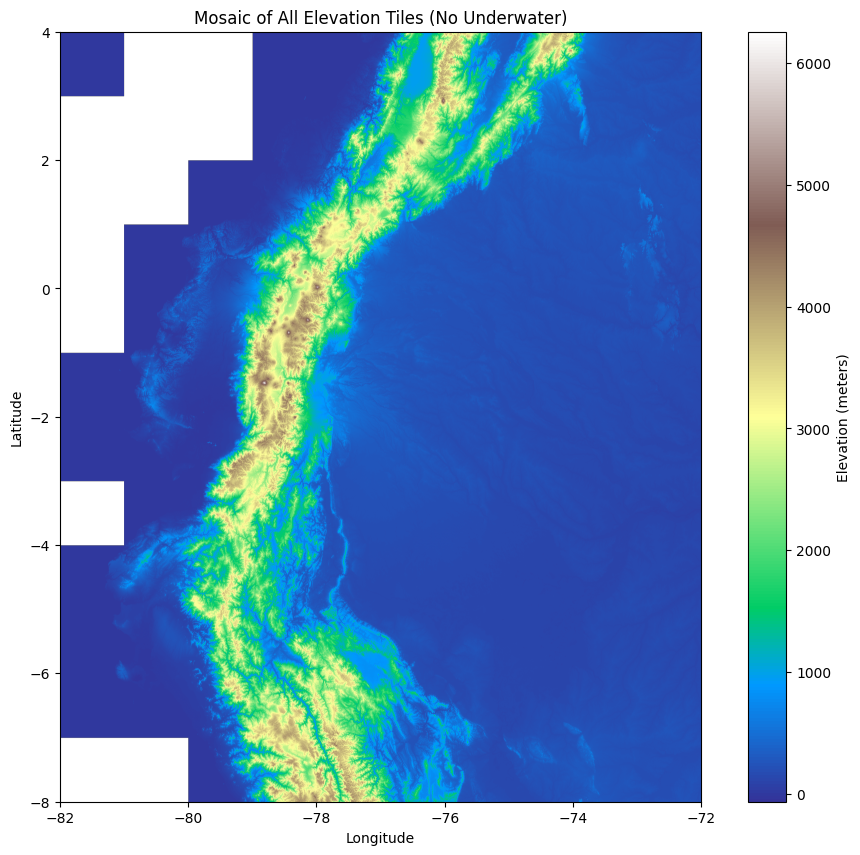

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Mask underwater (negative elevation) values
mosaic_masked = np.ma.masked_less(mosaic[0], -100)  # min in range is -67

plt.figure(figsize=(12, 10))

plt.imshow(
    mosaic_masked,
    cmap="terrain",
    extent=[
        out_trans.c,
        out_trans.c + out_trans.a * mosaic.shape[2],
        out_trans.f + out_trans.e * mosaic.shape[1],
        out_trans.f,
    ],
    origin="upper",
)

plt.colorbar(label="Elevation (meters)")

plt.title("Mosaic of All Elevation Tiles (No Underwater)")

plt.xlabel("Longitude")

plt.ylabel("Latitude")

plt.show()

In [13]:
min_value = mosaic_masked.min()
min_value

np.int16(-67)

In [14]:
import rasterio

# Export the mosaic as a GeoTIFF file
output_path = "mosaic_export.tif"
with rasterio.open(
    output_path,
    "w",
    driver="GTiff",
    height=mosaic.shape[1],
    width=mosaic.shape[2],
    count=1,
    dtype=mosaic.dtype,
    crs="EPSG:4326",
    transform=out_trans,
    nodata=-32768,
) as dst:
    dst.write(mosaic[0], 1)

print(f"Mosaic exported to {output_path}")

Mosaic exported to mosaic_export.tif


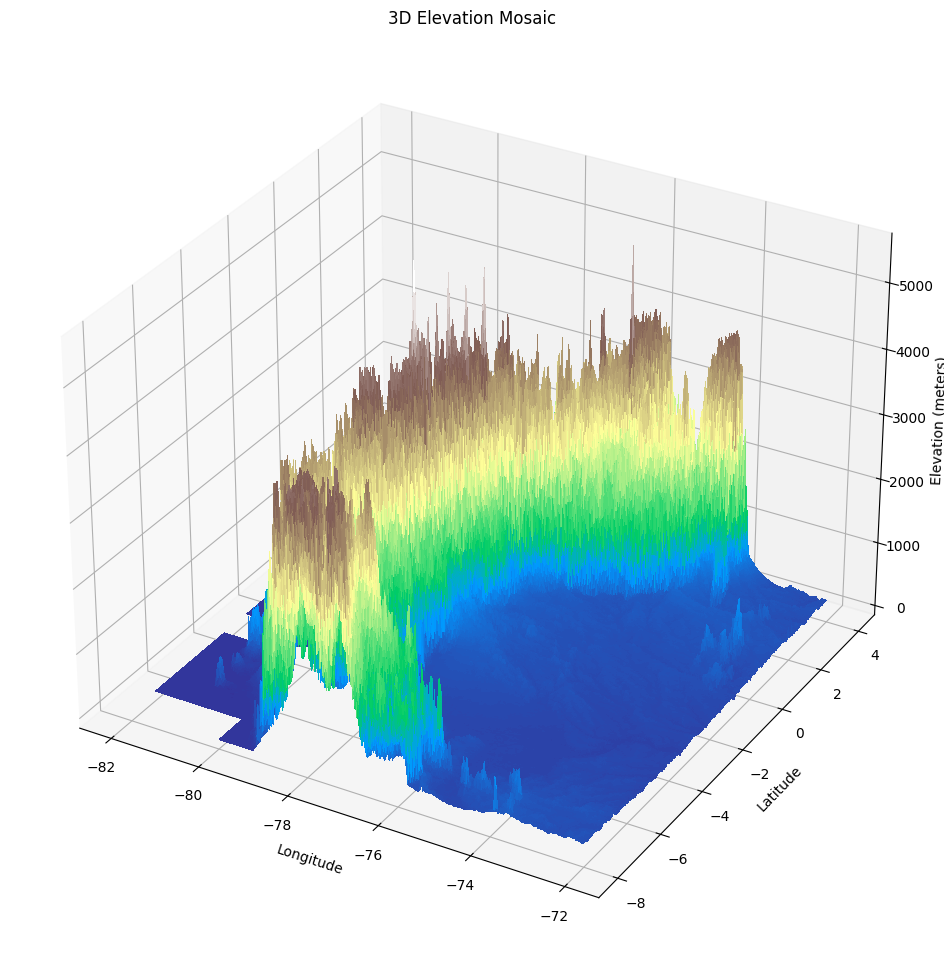

In [15]:
from mpl_toolkits.mplot3d import Axes3D

# Create meshgrid for the mosaic
mosaic_lon = np.linspace(
    out_trans.c, out_trans.c + out_trans.a * mosaic.shape[2], mosaic.shape[2]
)
mosaic_lat = np.linspace(
    out_trans.f, out_trans.f + out_trans.e * mosaic.shape[1], mosaic.shape[1]
)
X, Y = np.meshgrid(mosaic_lon, mosaic_lat)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection="3d")

# Downsample for performance if needed
stride = max(1, mosaic.shape[1] // 500)
ax.plot_surface(
    X[::stride, ::stride],
    Y[::stride, ::stride],
    mosaic_masked[::stride, ::stride],
    cmap="terrain",
    linewidth=0,
    antialiased=False,
    rstride=1,
    cstride=1,
)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Elevation (meters)")
ax.set_title("3D Elevation Mosaic")
plt.show()